This notebook is solely used to generate the plots for the article. <br />
The authors apologize to serious Matplotlib users for the lack of optimization and elegance of this notebook.

In [3]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
from typing import Optional
import numpy as np
import os
from strawberryfields.backends.tfbackend.states import FockStateTF
from math import exp
from src.utils import von_neumann_entropy, renyi_entropy
from src.utils import quadratures_density, make_gif
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch import set_float32_matmul_precision
set_float32_matmul_precision('high')
from torch.optim import AdamW
from tqdm import tqdm
from matplotlib import ticker

In [4]:
golden_mean = (np.sqrt(5.0)-1.0)/2.0

subplotlabelfont = {'fontweight': 'bold', 'fontsize': 9}

def format_axes(axes, position=(-.1, 1.02)):
    for i, ax in enumerate(axes, start=97):
        ax.text(*position, chr(i), fontdict=subplotlabelfont, weight='bold',
                transform=ax.transAxes)

def figsize(scale, aspect_ratio = golden_mean):
    fig_width_pt = 246.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch

    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*aspect_ratio              # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

rcparams = {                      # setup matplotlib to use latex for output
    "axes.labelsize": 12,               # LaTeX default is 10pt font.
    "axes.linewidth": 2,
    'lines.linewidth': 2,
    "xtick.major.width": 2,
    "ytick.major.width": 2,
    "lines.markersize":2,
    "font.size": 9,
    "legend.fontsize": 10,               # Make the legend/label fonts a little smaller
    "axes.spines.top": True,
    "axes.spines.right": True,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize(1.5),  
    "xtick.direction": "inout",
    "ytick.direction": "inout"# default fig size of 0.9 textwidth
    }

mpl.rcParams.update(rcparams)

dt=1e-3
steps=int(2e5)
x=np.array(list(range(0,steps)))*dt
a=1
a2=.4

### tick parameters
tick_dir = 'in' # out, inout
tick_len = 5
tick_width = 1

plt.style.use(['seaborn-whitegrid'])#(['Solarize_Light2'])

In [5]:
dir = 'logs/2023.02.21.13.19.23'
plots_path = os.path.join('./latex', 'figures')
os.makedirs(plots_path, exist_ok=True)
res = np.load(os.path.join(dir, 'results.npy'))
starting_distance = 0

binding_energies = res[:, starting_distance:, -1, -1]
states = res[:, starting_distance:, :-1, :-1]
distances = np.load(os.path.join(dir, 'distance_array.npy'))[starting_distance:]
thetas = np.load(os.path.join(dir, 'angle_array.npy'))
quadrature_grid = np.load(os.path.join(dir, 'quadrature_array.npy'))
entropy_array = von_neumann_entropy(states=states)
renyi_entropy_array = renyi_entropy(states=states, n=2)
correlation_array = np.load(os.path.join(dir, 'correlation_array.npy'))
bell_array = np.load(os.path.join(dir, 'bell_array.npy'))
startingDistance = [1, 2, 3, 5, 7, 8, 10, 12, 15, 18, 24, 22, 18, 17, 17, 16, 21, 25, 24] # starting at the first non-parallel angle

with open(os.path.join(dir, 'args.json')) as f:
    args = json.load(f)

In [6]:
def entropy_fit(r):
    expr = (1354.1190287327627 + 69.57059464705372/r**6 - 589.0017867913149/r**5 + 2177.9948912201044/r**4 - 4485.60849646864/r**3 + 5528.745912907768/r**2 - 3988.1254971335707/r + 203.0086635377917*r - 420.62415056426846*r**2 + 192.6852057844995*r**3 - 45.45103486645947*r**4 + 5.6428967627556075*r**5 - 0.292282473955571*r**6)/(-1 + exp(3.340009074510866/r))
    return expr

def fit_morse_quality(r):
    return 0.7562780555949897/exp(7.90810731120047*r)

def correlation_fit(r):
    def k(x, y, sigma):
        return exp(-(x - y)**2 / (2 * sigma**2))
    
    sigma = 0.04
    up = 0
    down = 0

    start = startingDistance[7]

    for i in range(distances[start:].shape[0]):
        up += k(r, distances[start:][i], sigma) * correlation_array[7][start:][i]
        down += k(r, distances[start:][i], sigma)
 
    return up / down

def interpolation_morse(r, angle_idx):
    r'''
    These are the Morse potential fit obtained in Mathematica
    '''
    
    if angle_idx == 1:
        expr = 5.580390309448237*(exp(-3.0377471897088193*(-0.528669782788294 + r)) - 2/exp(1.5188735948544096*(-0.528669782788294 + r)))
    elif angle_idx == 2:
        expr = 3.4274486627573997*(exp(-3.799380158605931*(-0.47973290114432926 + r)) - 2/exp(1.8996900793029654*(-0.47973290114432926 + r)))
    elif angle_idx == 3:
        expr = 2.285401169096024*(exp(-4.402463155249511*(-0.4631079255337017 + r)) - 2/exp(2.2012315776247555*(-0.4631079255337017 + r)))
    elif angle_idx == 4:
        expr = 1.551192171427588*(exp(-4.81570374860555*(-0.4642655447957261 + r)) - 2/exp(2.407851874302775*(-0.4642655447957261 + r)))
    elif angle_idx == 5:
        expr = 1.0598470742964785*(exp(-5.1410754088615755*(-0.4783898190284267 + r)) - 2/exp(2.5705377044307878*(-0.4783898190284267 + r)))
    elif angle_idx == 6:
        expr = 0.7148220809706628*(exp(-5.3904241278507286*(-0.5018955265663114 + r)) - 2/exp(2.6952120639253643*(-0.5018955265663114 + r)))
    elif angle_idx == 7:
        expr = 0.46331721539795195*(exp(-5.5069105743552305*(-0.5384565406606292 + r)) - 2/exp(2.7534552871776152*(-0.5384565406606292 + r)))
    elif angle_idx == 8:
        expr = 0.28495211368558043*(exp(-5.501660360933069*(-0.5868720195028256 + r)) - 2/exp(2.7508301804665347*(-0.5868720195028256 + r)))
    elif angle_idx == 9:
        expr = 0.16054553861792828*(exp(-5.406762370032314*(-0.6589019567964931 + r)) - 2/exp(2.703381185016157*(-0.6589019567964931 + r)))
    elif angle_idx == 10:
        expr = 0.0802423625900907*(exp(-5.2807411035440905*(-0.7610680973692473 + r)) - 2/exp(2.6403705517720453*(-0.7610680973692473 + r)))
    elif angle_idx == 11:
        expr = 0.031941895762222915*(exp(-4.8881023079372845*(-0.9318352120398004 + r)) - 2/exp(2.4440511539686423*(-0.9318352120398004 + r)))
    elif angle_idx == 12:
        expr = -0.21795992863678978*(exp(-18.93357243882598*(-0.419031099683263 + r)) - 2/exp(9.46678621941299*(-0.419031099683263 + r)))
    elif angle_idx == 13:
        expr = -4.596185038513766e8*(exp(-11.486738219445648*(3.3611808687392295 + r)) - 2/exp(5.743369109722824*(3.3611808687392295 + r)))
    elif angle_idx == 14:
        expr = -8.435877205314344e8*(exp(-9.835982910255005*(4.090374604186538 + r)) - 2/exp(4.917991455127503*(4.090374604186538 + r)))
    elif angle_idx == 15:
        expr = -5595.4996148289965*(-2*exp(3.473725867625206e-6*(199537.59265461436 + r)) + exp(6.947451735250412e-6*(199537.59265461436 + r)))
    elif angle_idx == 16:
        expr = -6257.5024012085705*(-2*exp(3.613860552846493e-6*(191800.01322388317 + r)) + exp(7.227721105692986e-6*(191800.01322388317 + r)))
    elif angle_idx == 17:
        expr = -78.2709544530638*(exp(-7.326961784623224*(1.1821855753944306 + r)) - 2/exp(3.663480892311612*(1.1821855753944306 + r)))
    elif angle_idx == 18:
        expr = -60.335480736907535*(exp(-6.655169258297058*(1.283760988719811 + r)) - 2/exp(3.327584629148529*(1.283760988719811 + r)))
    elif angle_idx == 19:
        expr = -59.1291656257202*(exp(-6.735608158749974*(1.248561482832166 + r)) - 2/exp(3.367804079374987*(1.248561482832166 + r)))
    return expr

def repulsion_vs_correlation(r):
    '''this is for angle_idx=7'''
    correlation = -0.46331721539795195*(2/exp(2.7534552871776152*(-0.5384565406606292 + r)))
    repulsion = 0.46331721539795195*(exp(-5.5069105743552305*(-0.5384565406606292 + r)))
    return correlation, repulsion

def repulsion_vs_correlation_2nd_derivative(r):
    '''this is for angle_idx=7'''
    correlation = -7.025293780360139/exp(2.7534552871776152*(-0.5384565406606292 + r))
    repulsion = 14.050587560720277/exp(5.5069105743552305*(-0.5384565406606292 + r))
    return correlation, repulsion

2023-05-11 15:28:39.635573: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-11 15:28:39.635836: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-11 15:28:39.635879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (uni-OptiPlex-7480-AIO): /proc/driver/nvidia/version does not exist
2023-05-11 15:28:39.637502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


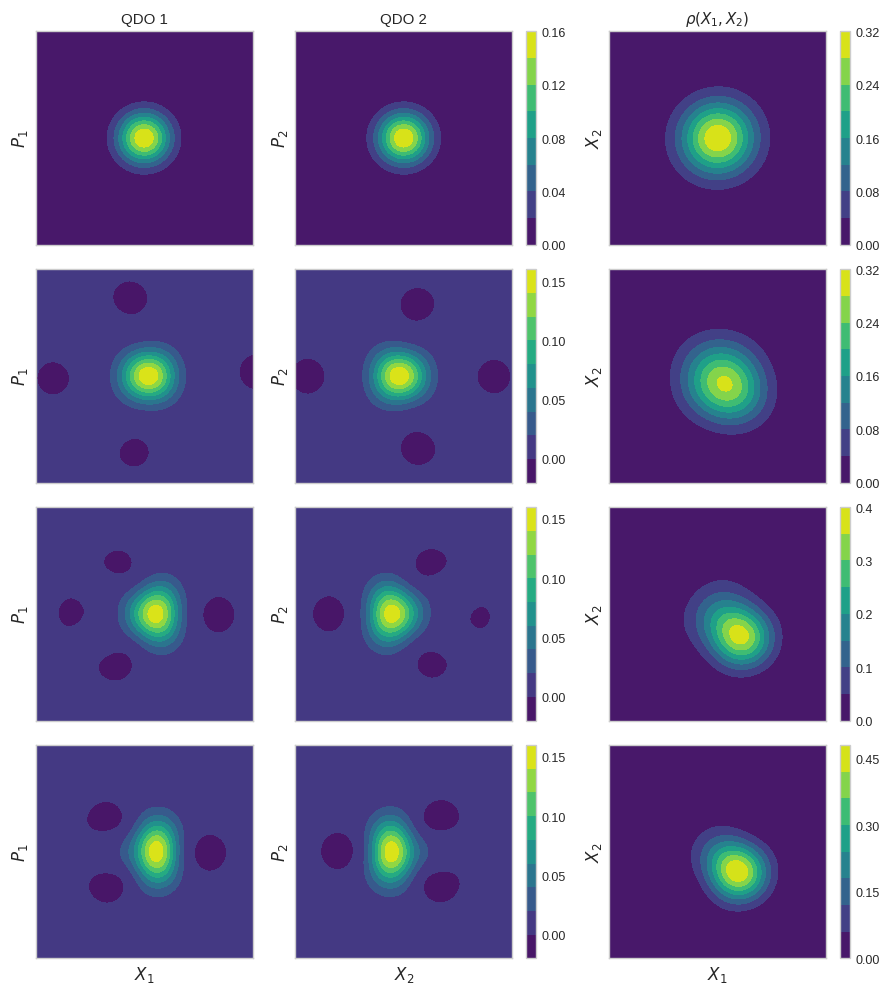

In [6]:
cmappa = 'viridis'
cmappa2= 'magma'
#cmappa = 'GnBu'
def plot_wigner(
    fig_dir: Optional[str],
    quadrature_grid: np.ndarray,
    states: np.ndarray,
    cutoff_dim: int = 5
) -> None:

    X, P = np.meshgrid(quadrature_grid, quadrature_grid)
    
    X1, X2 = np.meshgrid(quadrature_grid, quadrature_grid)

    state0 = FockStateTF(state_data=states[7, 180], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    state1 = FockStateTF(state_data=states[7, 72], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    state2 = FockStateTF(state_data=states[7, 42], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    state3 = FockStateTF(state_data=states[7, 26], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    w_qdo1_0 = state0.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_0 = state0.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo1_1 = state1.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_1 = state1.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo1_2 = state2.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_2 = state2.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo1_3 = state3.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_3 = state3.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    
    # large distance
    joint_density0 = quadratures_density(
        x=quadrature_grid,
        alpha=states[7, 180],
        num_modes=2,
        cutoff=cutoff_dim
    )

    # intermediate distance
    joint_density1 = quadratures_density(
        x=quadrature_grid,
        alpha=states[7, 72],
        num_modes=2,
        cutoff=cutoff_dim
    )

    # max entropy
    joint_density2 = quadratures_density(
        x=quadrature_grid,
        alpha=states[7, 42],
        num_modes=2,
        cutoff=cutoff_dim
    )

    # bound state
    joint_density3 = quadratures_density(
        x=quadrature_grid,
        alpha=states[7, 26],
        num_modes=2,
        cutoff=cutoff_dim
    )

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(9, 10), sharex=False, sharey=False, gridspec_kw={'width_ratios': [.8, 1, 1]})

    heatmap1_0 = axes[0, 0].contourf(X, P, w_qdo2_0, cmap = cmappa)
    axes[0, 0].set_title("QDO 1")
    heatmap2_0 = axes[0, 1].contourf(X, P, w_qdo1_0, cmap = cmappa)
    axes[0, 1].set_title("QDO 2")
    cbar = plt.colorbar(heatmap2_0, ax=axes[0,1])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    heatmap3_0 = axes[0, 2].contourf(X1, X2, joint_density0, cmap = cmappa)
    cbar = plt.colorbar(heatmap3_0, ax=axes[0,2])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    axes[0, 2].set_title(r"$\rho(X_1, X_2)$")
    axes[0, 0].set_ylabel(r"$d = 3.16$")

    heatmap1_1 = axes[1, 0].contourf(X, P, w_qdo2_1, cmap = cmappa)
    axes[1,0].set_ylabel('Y')
    heatmap2_1 = axes[1, 1].contourf(X, P, w_qdo1_1, cmap = cmappa)
    cbar = plt.colorbar(heatmap2_1, ax=axes[1,1])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    heatmap3_1 = axes[1, 2].contourf(X1, X2, joint_density1, cmap = cmappa)
    cbar = plt.colorbar(heatmap3_1, ax=axes[1,2])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    axes[1, 0].set_ylabel(r"$d = 1.36$")

    heatmap1_2 = axes[2, 0].contourf(X, P, w_qdo2_2, cmap = cmappa)
    heatmap2_2 = axes[2, 1].contourf(X, P, w_qdo1_2, cmap = cmappa)
    cbar = plt.colorbar(heatmap2_2, ax=axes[2,1])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    heatmap3_2 = axes[2, 2].contourf(X1, X2, joint_density2, cmap = cmappa)
    cbar = plt.colorbar(heatmap3_2, ax=axes[2,2])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    axes[2, 0].set_ylabel(r"$d = 0.82$")

    heatmap1_3 = axes[3, 0].contourf(X, P, w_qdo2_3, cmap = cmappa)
    axes[3,0].set_ylabel('Y')
    heatmap2_3 = axes[3, 1].contourf(X, P, w_qdo1_3, cmap = cmappa)
    cbar = plt.colorbar(heatmap2_3, ax=axes[3,1])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    heatmap3_3 = axes[3, 2].contourf(X1, X2, joint_density3, cmap = cmappa)
    
    cbar = plt.colorbar(heatmap3_3, ax=axes[3,2])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    axes[3, 0].set_ylabel(r"$d = 0.54$")

    for i in range(0,4):
        axes[i, 2].set_xlim(-3,3)
        axes[i, 2].set_ylim(-3,3)
        axes[i,0].yaxis.set_major_locator(plt.MaxNLocator(3))
        axes[i,1].yaxis.set_major_locator(plt.MaxNLocator(3))
        axes[i,2].yaxis.set_major_locator(plt.MaxNLocator(3))
        axes[i,0].set_ylabel(r'$P_1$')
        axes[i,1].set_ylabel(r'$P_2$')
        axes[i,2].set_ylabel(r'$X_2$')
        for j in range(0,3):
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
        
    axes[3,0].set_xlabel(r'$X_1$')
    axes[3,1].set_xlabel(r'$X_2$')
    axes[3,2].set_xlabel(r'$X_1$')

    fig.tight_layout(pad=1.0)
    plt.savefig(os.path.join(plots_path, 'wigners_joint.pdf'), dpi=300, transparent=False, bbox_inches='tight')

plot_wigner(
    fig_dir=None,
    quadrature_grid=quadrature_grid,
    states=states,
    cutoff_dim=args['cutoff_dim']
)

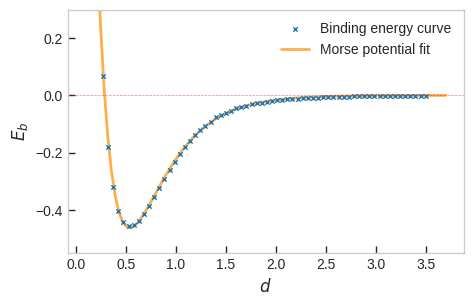

In [7]:
def plot_binding_curve_morse(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    angle_idx: int,
    ymin: Optional[float]=None,
    ymax: Optional[float]=None
) -> None:

    fig, axes = plt.subplots(nrows=1, ncols=1)

    line1, = axes.plot(
        np.linspace(0.1, 3.7, 100), 
        [interpolation_morse(r, angle_idx) for r in np.linspace(0.1, 3.7, 100)], 
        c='darkorange',
        alpha=0.7,
        label='Morse potential fit', 
        zorder=1
        
    )

    line0 = axes.scatter(
        distance_array[startingDistance[angle_idx-1]::3], 
        binding_energy_array[angle_idx, startingDistance[angle_idx-1]::3], 
        s=10, 
        marker='x',
        alpha=1,
        label='Binding energy curve', 
        zorder=2,
        linewidths=1
    )

    axes.axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )
    
    axes.set_xlabel(r'$d$')
    axes.set_ylabel(r'$E_b$')
    if ymin is not None and ymax is not None:
        axes.set_ylim(ymin, ymax)
    axes.grid(False)
    #axes.set_title(r'Binding energy for a pair of QDOs at the optimal angle $\theta=0.57$ rad')
    axes.legend(handles=[line0, line1])
    axes.tick_params(direction=tick_dir, length=tick_len, width=tick_width)
    #plt.show()
    plt.savefig(os.path.join(plots_path, 'binding.pdf'), dpi=300, transparent=False, bbox_inches='tight')

plot_binding_curve_morse(
    distance_array=distances,
    binding_energy_array=binding_energies,
    ymin=-0.55,
    ymax=0.3,
    angle_idx=7
)

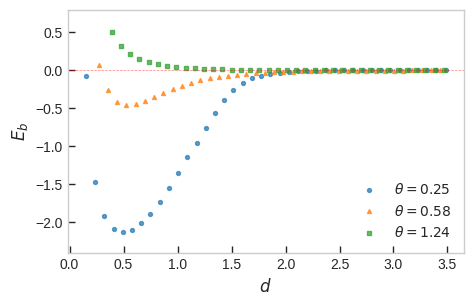

In [8]:
def plot_binding_multiple_binding_curves(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    angles: list,
    ymin: Optional[float]=None,
    ymax: Optional[float]=None
) -> None:

    fig, axes = plt.subplots(nrows=1, ncols=1)

    every = 5

    angle_idx0 = angles[0]
    line0 = axes.scatter(
        distance_array[startingDistance[angle_idx0-1]::every], 
        binding_energy_array[angle_idx0, startingDistance[angle_idx0-1]::every], 
        s=8, 
        marker='o',
        alpha=0.7,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx0]), 
        zorder=2,
        linewidths=1
    )
    
    angle_idx1 = angles[1]
    line1 = axes.scatter(
        distance_array[startingDistance[angle_idx1-1]::every], 
        binding_energy_array[angle_idx1, startingDistance[angle_idx1-1]::every], 
        s=8, 
        marker='^',
        alpha=0.7,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx1]),  
        zorder=2,
        linewidths=1
    )

    angle_idx2 = angles[2]
    line2 = axes.scatter(
        distance_array[startingDistance[angle_idx2-1]::every], 
        binding_energy_array[angle_idx2, startingDistance[angle_idx2-1]::every], 
        s=8, 
        marker='s',
        alpha=0.7,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx2]), 
        zorder=2,
        linewidths=1
    )

    axes.axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )
    
    axes.set_xlabel(r'$d$')
    axes.set_ylabel(r'$E_b$')
    if ymin is not None and ymax is not None:
        axes.set_ylim(ymin, ymax)
    axes.grid(False)
    #axes.set_title(r'Binding energy for a pair of QDOs at the optimal angle $\theta=0.57$ rad')
    axes.legend(handles=[line0, line1, line2])
    axes.tick_params(direction=tick_dir, length=tick_len, width=tick_width)
    #plt.show()
    plt.savefig(os.path.join(plots_path, 'binding_vs_smooth.pdf'), dpi=300, transparent=False, bbox_inches='tight')

plot_binding_multiple_binding_curves(
    distance_array=distances,
    binding_energy_array=binding_energies,
    angles=[3, 7, 15],
    ymin=-2.4,
    ymax=0.8,
)

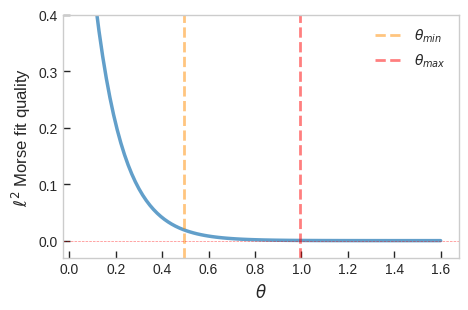

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1)

line0, = axes.plot(
    np.linspace(0.05, 1.6, 100), 
    [fit_morse_quality(r) for r in np.linspace(0.01, 1.6, 100)], 
    alpha=0.7,
    linewidth=2.5
)

line1 = axes.axvline(x=0.4960409453036515, label=r'$\theta_{min}$', c='darkorange', alpha=0.5, linestyle = 'dashed')
line2 = axes.axvline(x=0.992081890607303, label=r'$\theta_{max}$', c='red', alpha=0.5, linestyle = 'dashed')

axes.axhline(
    y = 0.0, 
    color = 'red', 
    linestyle = '--',
    alpha=0.5,
    lw=0.5
)

axes.legend(handles=[line0, line1, line2])
axes.tick_params(direction=tick_dir, length=tick_len, width=tick_width)

axes.set_xlabel(r'$\theta$')
axes.set_ylabel(r'$\ell^2$ Morse fit quality')
axes.set_ylim(-0.03, 0.4)
axes.grid(False)
plt.savefig(os.path.join(plots_path, 'morse_quality.pdf'), dpi=300, transparent=False, bbox_inches='tight')

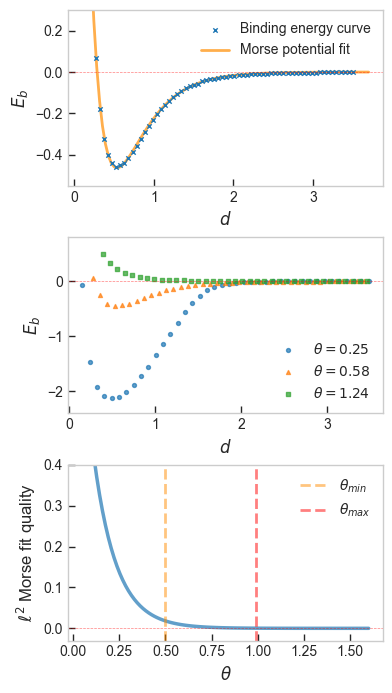

In [56]:
def plot_binding_curve_morse(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    angle_idx: int,
    angles: list,
    ymin: Optional[float]=None,
    ymax: Optional[float]=None
) -> None:

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4,7))

    line1, = axes[0].plot(
        np.linspace(0.1, 3.7, 100), 
        [interpolation_morse(r, angle_idx) for r in np.linspace(0.1, 3.7, 100)], 
        c='darkorange',
        alpha=0.7,
        label='Morse potential fit', 
        zorder=1
        
    )

    line0 = axes[0].scatter(
        distance_array[startingDistance[angle_idx-1]::3], 
        binding_energy_array[angle_idx, startingDistance[angle_idx-1]::3], 
        s=10, 
        marker='x',
        alpha=1,
        label='Binding energy curve', 
        zorder=2,
        linewidths=1
    )

    axes[0].axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )
    
    axes[0].set_xlabel(r'$d$')
    axes[0].set_ylabel(r'$E_b$')
    axes[0].set_ylim(ymin[0], ymax[0])
    axes[0].grid(False)
    #axes[0].set_title(r'Binding energy for a pair of QDOs at the optimal angle $\theta=0.57$ rad')
    axes[0].legend(handles=[line0, line1])
    axes[0].tick_params(direction=tick_dir, length=tick_len, width=tick_width)
    #plt.show()
    #plt.savefig(os.path.join(plots_path, 'binding.pdf'), dpi=300, transparent=False, bbox_inches='tight')

    every = 5

    angle_idx0 = angles[0]
    line0 = axes[1].scatter(
        distance_array[startingDistance[angle_idx0-1]::every], 
        binding_energy_array[angle_idx0, startingDistance[angle_idx0-1]::every], 
        s=8, 
        marker='o',
        alpha=0.7,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx0]), 
        zorder=2,
        linewidths=1
    )
    
    angle_idx1 = angles[1]
    line1 = axes[1].scatter(
        distance_array[startingDistance[angle_idx1-1]::every], 
        binding_energy_array[angle_idx1, startingDistance[angle_idx1-1]::every], 
        s=8, 
        marker='^',
        alpha=0.7,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx1]),  
        zorder=2,
        linewidths=1
    )

    angle_idx2 = angles[2]
    line2 = axes[1].scatter(
        distance_array[startingDistance[angle_idx2-1]::every], 
        binding_energy_array[angle_idx2, startingDistance[angle_idx2-1]::every], 
        s=8, 
        marker='s',
        alpha=0.7,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx2]), 
        zorder=2,
        linewidths=1
    )

    axes[1].axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )
    
    axes[1].set_xlabel(r'$d$')
    axes[1].set_ylabel(r'$E_b$')
    axes[1].set_ylim(ymin[1], ymax[1])
    axes[1].grid(False)
    #axes[1].set_title(r'Binding energy for a pair of QDOs at the optimal angle $\theta=0.57$ rad')
    axes[1].legend(handles=[line0, line1, line2])
    axes[1].tick_params(direction=tick_dir, length=tick_len, width=tick_width)
    #plt.show()

    line0, = axes[2].plot(
    np.linspace(0.05, 1.6, 100), 
    [fit_morse_quality(r) for r in np.linspace(0.01, 1.6, 100)], 
    alpha=0.7,
    linewidth=2.5
    )

    line1 = axes[2].axvline(x=0.4960409453036515, label=r'$\theta_{min}$', c='darkorange', alpha=0.5, linestyle = 'dashed')
    line2 = axes[2].axvline(x=0.992081890607303, label=r'$\theta_{max}$', c='red', alpha=0.5, linestyle = 'dashed')

    axes[2].axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )

    axes[2].legend(handles=[line0, line1, line2])
    axes[2].tick_params(direction=tick_dir, length=tick_len, width=tick_width)

    axes[2].set_xlabel(r'$\theta$')
    axes[2].set_ylabel(r'$\ell^2$ Morse fit quality')
    axes[2].set_ylim(-0.03, 0.4)
    axes[2].grid(False)

    plt.tight_layout(h_pad=0.3)

    plt.savefig(os.path.join(plots_path, 'binding_3_figs.pdf'), dpi=300, transparent=False, bbox_inches='tight')

plot_binding_curve_morse(
    distance_array=distances,
    binding_energy_array=binding_energies,
    angles=[3, 7, 15],
    ymin=[-0.55, -2.4],
    ymax=[0.3, 0.8],
    angle_idx=7
)

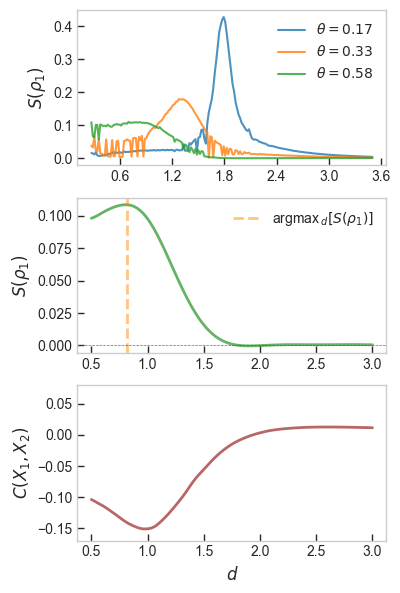

In [53]:
def plot_entropy() -> None:

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(4,6))
    line0, = axes[1].plot(
        np.linspace(0.5, 3.0, 100), 
        [entropy_fit(r) for r in np.linspace(0.5, 3.0, 100)], 
        alpha=0.6,
        c='green'
    )

    line1, = axes[2].plot(
        np.linspace(0.5, 3.0, 100), 
        [correlation_fit(r) for r in np.linspace(0.5, 3.0, 100)], 
        c='darkred',
        alpha=0.6,
        linewidth=2
    )

    axes[1].set_ylabel(r'$S(\rho_1)$')
    axes[1].grid(False)
    line2 = axes[1].axvline(x=0.81758794, label=r'argmax$\,_d[S(\rho_1)]$', linestyle = 'dashed', color = 'darkorange', alpha=0.5)
    axes[1].legend(handles=[line0, line2])
    axes[1].tick_params(direction=tick_dir, length=tick_len, width=tick_width)
    #axes[0].tick_params(
    #axis='x',          # changes apply to the x-axis
    #which='both',      # both major and minor ticks are affected
    #bottom=False,      # ticks along the bottom edge are off
    #top=False,         # ticks along the top edge are off
    #labelbottom=False) # labels along the bottom edge are off
    axes[1].tick_params(direction=tick_dir, length=tick_len, width=tick_width)

    axes[2].tick_params(direction=tick_dir, length=tick_len, width=tick_width)
    axes[2].legend(handles=[line1])
    axes[2].set_ylabel(r'$C(X_1, X_2)$')
    axes[2].set_ylim(-0.17, 0.08)
    axes[2].grid(False)

    axes[1].axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )

    axes[1].axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )

    arr = [2,4,7]

    for i in range(0,3):
        j = arr[i]
        ent = entropy_array[arr[i], starting_distance:]
        line0, = axes[0].plot(
            distances[starting_distance:][np.arange(0,len(states[0]), 1)[10:]], 
            ent[10:], 
            label = r'$\theta = {}$'.format(np.round(thetas[j], 2)),
            lw=1.5,
            alpha=0.8,
        )

    axes[0].legend()
    axes[0].set_ylabel(r'$S\left(\rho_1\right)$')
    axes[0].grid(False)
    axes[0].xaxis.set_major_locator(plt.MaxNLocator(6))
    axes[0].tick_params(direction=tick_dir, length=tick_len, width=tick_width)
    axes[2].set_xlabel(r'$d$')
    axes[0].legend()

    plt.tight_layout()
    
    plt.savefig(os.path.join(plots_path, 'entropy_correlation_3figs.pdf'), dpi=300, transparent=False, bbox_inches='tight')

plot_entropy()

In [12]:
def inner_coh(alpha, beta, state):
    """
    Should be <alpha, beta|state>
    """
    factors = torch.exp(-0.5*((alpha.abs())**2 + (beta.abs())**2))
    somma = 0
    for i in range(0,len(state[0,:])):
        for j in range(0,len(state[0,:])):
            somma += state[i,j]*torch.conj(alpha**i)*torch.conj(beta**j)/((np.math.factorial(i)*np.math.factorial(j))**0.5)
    return factors*somma

def normalization(alpha, beta, theta):
    """
    Should be normalization N of |cat state> = (N**-1)*(|alpa, beta> + exp(i*theta)|-alpha, -beta>)
    """
    factor = torch.exp(-2*(alpha.abs()**2 + beta.abs()**2))
    
    return (2*(1+factor*torch.cos(theta)))**0.5

class Fidelity(nn.Module):
    def __init__(self, alpha_init = 0. + 0.j, delta_init = 0. + 0.j) -> None:
        super().__init__()
        
        self.alpha = torch.nn.Parameter(torch.tensor([alpha_init]))
        self.delta = torch.nn.Parameter(torch.tensor([delta_init]))
        self.theta = torch.tensor([0.])
        
    def forward(self, state):
        inner_1 = inner_coh(self.alpha - self.delta, -self.alpha + self.delta, state)
        inner_2 = inner_coh(-self.alpha - self.delta, self.alpha + self.delta, state)*torch.exp(1.j*self.theta.real)
        normalize = normalization(self.alpha, self.alpha, self.theta.real)
        return ((inner_1 + inner_2)/normalize).abs()**2

def fit_cat_state(stato, alpha_init = 0. + 0.j, delta_init = 0. + 0.j):
    stato = torch.tensor(stato)
    model = Fidelity(alpha_init, delta_init)
    optimizer = AdamW(model.parameters(), lr=1e-1, maximize = True)
    prev_fi = torch.tensor(0.)
    fi = torch.tensor(1.)
    e = 0

    while torch.abs(fi-prev_fi)>=1e-6:
        e+=1
        prev_fi = fi
        fi = model(stato)
        optimizer.zero_grad()
        fi.backward()
        optimizer.step()
        if e%100 == 0:
            if fi.item()>1:
                temp = []
                for param in model.parameters():
                    temp.append(param[0].item())
            
    temp = []
    for param in model.parameters():
        temp.append(param[0].item())
    
    return fi.item(), temp

curves = []
parameteris = []
for theta_idx in [2,4,7]:
    fis = []
    parametri = []
    for i in np.arange(0,len(states[0]), 1):
        stato = states[theta_idx, i]
        if i == 0:
            fi, param = fit_cat_state(stato)
        else:
            fi, param = fit_cat_state(stato, param[0], param[1])
        fis.append(fi)
        parametri.append(param)
    curves.append(fis)
    parameteris.append(parametri)

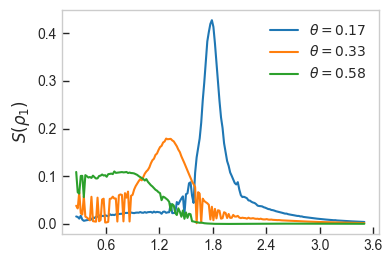

In [28]:
def plot_alpha_delta_rho() -> None:

    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(4,2.7))

    arr = [2,4,7]

    for i in range(0,3):
        j = arr[i]
        ent = entropy_array[arr[i], starting_distance:]
        #line0, = axes[0].plot(
        line0, = axes.plot(
            distances[starting_distance:][np.arange(0,len(states[0]), 1)[10:]], 
            ent[10:], 
            label = r'$\theta = {}$'.format(np.round(thetas[j], 2)),
            lw=1.5
        )

    axes.legend()
    axes.set_ylabel(r'$S\left(\rho_1\right)$')
    axes.grid(False)
    axes.xaxis.set_major_locator(plt.MaxNLocator(6))
    axes.tick_params(direction=tick_dir, length=tick_len, width=tick_width)
    axes.legend()

    # axes[0].legend()
    # axes[0].set_ylabel(r'$S\left(\rho_1\right)$')
    # axes[0].grid(False)
    # axes[0].xaxis.set_major_locator(plt.MaxNLocator(6))
    # axes[0].tick_params(direction=tick_dir, length=tick_len, width=tick_width)
    # axes[0].legend()

    #for i in range(0,3):
    #    j = arr[i]
    #    par = np.array(parameteris[i])
    #    line1, = axes[1].plot(
    #        distances[starting_distance:][np.arange(0,len(states[0]), 1)[10:]], 
    #        np.abs(np.real(par[10:,0])), 
    #        label = r'$\theta = {}$'.format(np.round(thetas[j], 2)),
    #        lw=1.5
    #    )
#
    #axes[1].set_ylabel(r'$|Re\left(\alpha\right)|$')
    #axes[1].grid(False)
    #axes[1].tick_params(direction=tick_dir, length=tick_len, width=tick_width)
#
    #for i in range(0,3):
    #    j = arr[i]
    #    par = np.array(parameteris[i])
    #    line2, = axes[2].plot(
    #        distances[starting_distance:][np.arange(0,len(states[0]), 1)[10:]], 
    #        np.abs(np.real(par[10:,1])), 
    #        label = r'$\theta = {}$'.format(np.round(thetas[j], 2)),
    #        lw=1.5
    #    )
#
    #axes[2].set_ylabel(r'$|Re\left(\delta\right)|$')
    #axes[2].set_xlabel(r'd')
    #axes[2].grid(False)
    #axes[2].tick_params(direction=tick_dir, length=tick_len, width=tick_width)

    plt.tight_layout()
    #plt.savefig(os.path.join(plots_path, 'alpha_delta_rho.pdf'), dpi=300, transparent=False, bbox_inches='tight')
    plt.savefig(os.path.join(plots_path, 'entropy_3_angles.pdf'), dpi=300, transparent=False, bbox_inches='tight')

plot_alpha_delta_rho()

In [ ]:
def moving_avg(arr, hwindow):
    newarr = []
    for i in range(hwindow, len(arr)-hwindow):
        newarr.append(arr[i-hwindow:i+hwindow].mean())
    return np.array(newarr)

FIs = []
params = []
for i in [2, 4, 7]:
    jmax = np.argmax(entropy_array[i, starting_distance:])
    stato = states[i, jmax]
    interatomic = distances[starting_distance:][jmax]
    FI, param = fit_cat_state(stato)
    print(FI, param)
    FIs.append(FI)
    params.append(param)

deltas = []
window = 1
#for angle_idx in [2, 3, 4, 5, 7]:
#        
#    avg_d = moving_avg(distances[starting_distance:], window)
#    avg_ent = moving_avg(entropy_array[angle_idx, starting_distance:], window)
#    avg_energy = moving_avg(binding_energies[angle_idx, starting_distance:], window)
#    deltas.append(avg_d[np.argmax(avg_ent)])
#    plt.scatter(thetas[angle_idx], avg_ent.max())

from scipy.special import hermite as H

def func(x, n):
    hermit = H(n)
    exponential = np.exp(-0.5*(x**2))
    const = ((2**(n))*np.math.factorial(n)*((np.pi)**(0.5)))**(-0.5)
    return exponential*hermit(x)*const

def func2(x1, x2, n1max, n2max, state):
    somma = 0
    for i in range(0, n1max):
        for j in range(0,n2max):
            somma+=state[i,j]*func(x1, i)*func(x2, j)
    return somma

def func2_simm(x, n1max, n2max, state):
    somma = 0
    for i in range(0, n1max):
        for j in range(0,n2max):
            somma+=state[i,j]*func(-x, i)*func(x, j)
    return somma

def func3(x1, x2, p1, p2, y1, y2, dy, n1max, n2max, state):
    psi = func2(x1-y1, x2-y2, n1max, n2max, state)
    psistar = np.conjugate(func2(x1+y1, x2+y2, n1max, n2max, state))
    expo = np.exp(2*1j*(p1*y1 + p2*y2))
    return psistar*psi*expo*dy*dy

def func3_diag(x, p, y1, y2, dy, n1max, n2max, state):
    return func3(x, -x, p, -p, y1, y2, dy, n1max, n2max, state)

def func3_simm(x, p, y, dy, n1max, n2max, state):
    psi = func2_simm(x-y, n1max, n2max, state)
    psistar = np.conjugate(func2_simm(x+y, n1max, n2max, state))
    expo = np.exp(2*1j*(p*y))
    return psistar*psi*expo*dy

def position_entangled_cats(x1, x2, alpha, beta, theta, delta):
    N = normalization(torch.tensor(alpha), torch.tensor(beta), torch.tensor(theta))
    N = N.item()
    factor = np.exp(-(np.imag(alpha)**2 + np.imag(beta)**2))/(N*(np.pi**.5))
    part1 = np.exp(-0.5*((x1-(2**0.5)*(alpha-delta))**2 + (x2-(2**0.5)*(beta+delta))**2))
    part2 = np.exp(1j*theta)*np.exp(-0.5*((x1+(2**0.5)*(alpha+delta))**2 + (x2+(2**0.5)*(beta-delta))**2))
    return factor*(part1 + part2)

def joint_density_cats(x1, x2, alpha, beta, theta, delta):
    return np.absolute(position_entangled_cats(x1, x2, alpha, beta, theta, delta))**2

def Wigner_for_entangled_cats (x1, x2, p1, p2, y1, y2, dy, alpha, beta, theta, delta):
    psi = position_entangled_cats(x1-y1, x2-y2, alpha, beta, theta, delta)
    psistar = np.conjugate(position_entangled_cats(x1+y1, x2+y2, alpha, beta, theta, delta))
    expo = np.exp(2*1j*(p1*y1 + p2*y2))
    return psistar*psi*expo*dy*dy

params = np.array(params)
wigners2 = []
densities = []
for t in [0,1,2]:
    max_idx = np.argmax(entropy_array[t, :])
    d = 2.5
    steps = 40
    x = np.linspace(-d,d,steps)
    p = np.linspace(-d,d,steps)
    y1ax = np.linspace(-d,d,steps)
    dy = (2*d)/steps
    summa = 0
    for y1 in tqdm(y1ax):
        for y2 in y1ax:
            summa+=Wigner_for_entangled_cats(x[:,None, None, None],
                        x[None, :, None, None],
                        p[None, None, :, None],
                        p[None, None, None, :],
                        y1,
                        y2,
                        dy, params[t, 0], - params[t, 0], 0., params[t, 1])
    
    densities.append(joint_density_cats(x[:, None], x[None, :], params[t, 0], - params[t, 0], 0., params[t, 1]))
    diagw = []
    for i in range(0,len(y1ax)):
        tmp = []
        for j in range(0,len(y1ax)):
            tmp.append(summa[len(y1ax) - i - 1, i, len(y1ax) - j - 1, j])
        diagw.append(tmp)
    diagw = np.array(diagw)
    wigners2.append(diagw)

wigners = []
for t in [2, 4, 7]:
    max_idx = np.argmax(entropy_array[t, :])
    d = 2.5
    steps = 40
    x = np.linspace(-d,d,steps)
    p = np.linspace(-d,d,steps)
    y1ax = np.linspace(-d,d,steps)
    dy = (2*d)/steps
    summa = 0
    for y1 in tqdm(y1ax):
        for y2 in y1ax:
            summa+=func3(x[:,None, None, None],
                        x[None, :, None, None],
                        p[None, None, :, None],
                        p[None, None, None, :],
                        y1,
                        y2,
                        dy, 5, 5, np.round(states[t, max_idx, :, :], 3))
    diagw = []
    for i in range(0,len(y1ax)):
        tmp = []
        for j in range(0,len(y1ax)):
            tmp.append(summa[len(y1ax) - i - 1, i, len(y1ax) - j - 1, j])
        diagw.append(tmp)
    diagw = np.array(diagw)
    wigners.append(diagw)

plt.rc('axes', titlesize=12)        # Controls Axes Title
plt.rc('axes', labelsize=12)        # Controls Axes Labels
plt.rc('xtick', labelsize=12)       # Controls x Tick Labels
plt.rc('ytick', labelsize=12)       # Controls y Tick Labels
plt.rc('legend', fontsize=12)       # Controls Legend Font
plt.rc('figure', titlesize=12)

def wigner_cat_state(alpha_r, alpha_i, beta_r, beta_i, theta):
    alpha = alpha_r + 1j * alpha_i
    beta = beta_r + 1j * beta_i
    normalization = 2 / np.pi
    cos_theta = np.cos(2 * theta)
    re_alpha_beta = np.real(alpha * beta)
    wigner = normalization * np.exp(-2 * (np.abs(alpha)**2 + np.abs(beta)**2)) * cos_theta * np.cos(4 * re_alpha_beta)
    return wigner

def potential(x, y, d, theta):
    
    ee_int = ((x-y)**2 + d**2 - 2*(y-x)*d*np.cos(theta))**(-0.5)
        
    return ( + x**2 + y**2 - (x**2 + d**2 - 2*x*d*np.cos(np.pi - theta))**(-0.5) + ee_int - (y**2 + d**2 - 2*y*d*np.cos(theta))**(-0.5) )

def potential_derivative_mag(x, y, d, theta, eps):
    x_comp = (potential(x+eps, y, d, theta) - potential(x, y, d, theta))/eps
    y_comp = (potential(x, y+eps, d, theta) - potential(x, y, d, theta))/eps
    return np.linalg.norm(-np.array([x_comp, y_comp]), axis = 0)   

d = 8
fig, axs = plt.subplots(2, 3, figsize=(d, d*golden_mean), )
    
arr =  [2, 4, 7]

for i in range(0,len(axs[0,:])):
    ind = len(axs[0,:])-i-1
    axs[0,i].set_title(r'$\theta = {}$'.format(np.round(thetas[arr[i]], 2)), fontsize = 16)
    c = axs[0,i].contourf(x, p, wigners[ind].T, 30, cmap = 'RdYlBu_r')
    
    cbar = plt.colorbar(c, ax = axs[0,i])
    tick_locator = ticker.MaxNLocator(nbins=3)
    cbar.locator = tick_locator
    cbar.update_ticks()
    axs[0,i].set_xticks([])
    if i !=0:
        axs[0,i].set_yticks([])

for i in range(0,len(axs[1,:])):
    ind = len(axs[1,:])-i-1
    
    c = axs[1,i].contourf(x, p, wigners2[ind].T, 30, cmap = 'RdYlBu_r')
    
    cbar = plt.colorbar(c, ax = axs[1,i])
    tick_locator = ticker.MaxNLocator(nbins=3)
    cbar.locator = tick_locator
    cbar.update_ticks()
    if i !=0:
        axs[1,i].set_yticks([])

fig.supxlabel(r'$X$', fontsize = 16)
fig.supylabel(r'$P$', fontsize = 16)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.savefig(os.path.join(plots_path, 'ground_cat_wigner.pdf'))

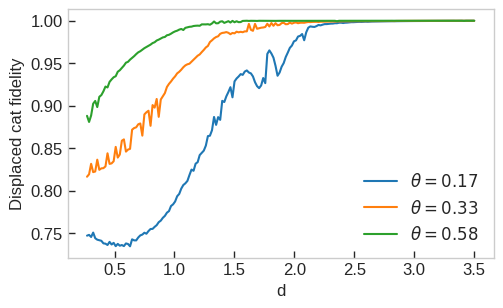

In [25]:
arr = [2,4,7]
for i in range(0,3):
    j = arr[i]
    fis = curves[i]
    plt.plot(
        distances[starting_distance:][np.arange(0,len(states[0]), 1)[10:]], 
        fis[10:], 
        label = r'$\theta = {}$'.format(np.round(thetas[j], 2)),
        lw=1.5
    )
plt.legend()
plt.ylabel('Displaced cat fidelity')
plt.xlabel(r'd')
plt.grid(False)
plt.tight_layout()

plt.MaxNLocator(6)
plt.tick_params(direction=tick_dir, length=tick_len, width=tick_width)

plt.savefig(os.path.join(plots_path, 'fidelities.pdf'))

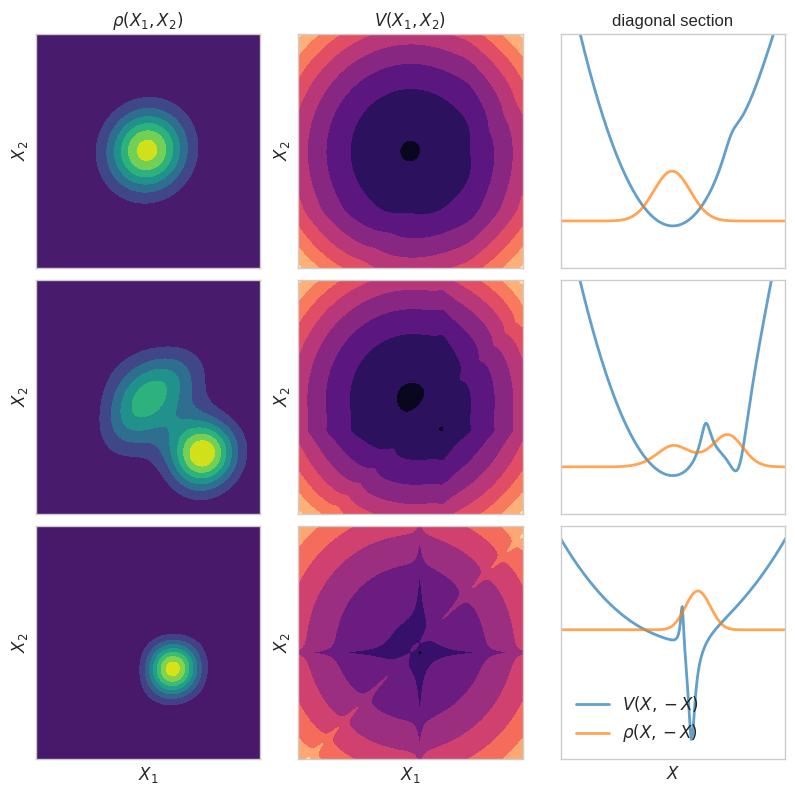

In [26]:
def potential(x, y, d, theta):
    
    ee_int = ((x-y)**2 + d**2 - 2*(y-x)*d*np.cos(theta))**(-0.5)
        
    return ( + x**2 + y**2 - (x**2 + d**2 - 2*x*d*np.cos(np.pi - theta))**(-0.5) + ee_int - (y**2 + d**2 - 2*y*d*np.cos(theta))**(-0.5) )

cmappa = 'viridis'
def plot_wigner(
    fig_dir: Optional[str],
    quadrature_grid: np.ndarray,
    states: np.ndarray,
    cutoff_dim: int = 5
) -> None:

    X, P = np.meshgrid(quadrature_grid, quadrature_grid)
    X1, X2 = np.meshgrid(quadrature_grid, quadrature_grid)

    state0 = FockStateTF(state_data=states[2, 180], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    state1 = FockStateTF(state_data=states[2, 99], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    state2 = FockStateTF(state_data=states[2, 24], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    w_qdo1_0 = state0.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_0 = state0.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo1_1 = state1.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_1 = state1.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo1_2 = state2.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_2 = state2.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    
    # large distance
    joint_density0 = quadratures_density(
        x=quadrature_grid,
        alpha=states[2, 180],
        num_modes=2,
        cutoff=cutoff_dim
    )

    # intermediate distance
    joint_density1 = quadratures_density(
        x=quadrature_grid,
        alpha=states[2, 99],
        num_modes=2,
        cutoff=cutoff_dim
    )

    # max entropy
    joint_density2 = quadratures_density(
        x=quadrature_grid,
        alpha=states[2, 24],
        num_modes=2,
        cutoff=cutoff_dim
    )

    # large distance
    section_joint_density0 = np.diagonal(joint_density0)

    # intermediate distance
    section_joint_density1 = quadratures_density(
        x=quadrature_grid,
        alpha=states[2, 99],
        num_modes=2,
        cutoff=cutoff_dim
    )

    # max entropy
    section_joint_density2 = quadratures_density(
        x=quadrature_grid,
        alpha=states[2, 24],
        num_modes=2,
        cutoff=cutoff_dim
    )

    potentiald_1 = []
    d = 3.18
    theta = 0.1653
    for x in quadrature_grid:
        pot = []
        for y in quadrature_grid:
            pot.append(potential(x,y,d,theta))
        potentiald_1.append(pot)

    potentiald_2 = []
    d = 1.79
    theta = 0.1653
    for x in quadrature_grid:
        pot = []
        for y in quadrature_grid:
            pot.append(potential(x,y,d,theta))
        potentiald_2.append(pot)

    potentiald_3 = []
    d = 0.51
    theta = 0.1653
    for x in quadrature_grid:
        pot = []
        for y in quadrature_grid:
            pot.append(potential(x,y,d,theta))
        potentiald_3.append(pot)

    section_potentiald_1 = []
    d = 3.18
    theta = 0.1653
    for x in quadrature_grid:
        section_potentiald_1.append(potential(-x,x,d,theta))

    section_potentiald_2 = []
    d = 1.79
    theta = 0.1653
    for x in quadrature_grid:
        section_potentiald_2.append(potential(-x,x,d,theta))

    section_potentiald_3 = []
    d = 0.51
    theta = 0.1653
    for x in quadrature_grid:
        section_potentiald_3.append(potential(-x,x,d,theta))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8), sharex=False, sharey=False, gridspec_kw={'width_ratios': [1, 1, 1]})

    axes[0, 2].plot(
        quadrature_grid, 
        section_potentiald_1, 
        alpha=0.7,
    )
    
    axes[0, 2].plot(
        quadrature_grid, 
        [10*joint_density0.numpy()[len(quadrature_grid)-i-1, i] for i in range(0,len(quadrature_grid))], 
        alpha=0.7,
        label = r'$\rho(X, -X)$'
    )
    
    
    heatmap1_0 = axes[0, 1].contourf(quadrature_grid, quadrature_grid, potentiald_1, cmap = 'magma')
    axes[0, 1].set_title(r"$V(X_1,X_2)$")
    heatmap3_0 = axes[0, 0].contourf(X1, X2, joint_density0, cmap = cmappa)
    axes[0, 0].set_title(r"$\rho(X_1, X_2)$")

    plt2 = axes[1, 2].plot(
        quadrature_grid, 
        section_potentiald_2, 
        alpha=0.7
    )
    axes[1, 2].plot(
        quadrature_grid, 
        [10*joint_density1.numpy()[len(quadrature_grid)-i-1, i] for i in range(0,len(quadrature_grid))], 
        alpha=0.7,
        label = r'$\rho(X, -X)$'
    )
    heatmap1_1 = axes[1, 1].contourf(quadrature_grid, quadrature_grid, potentiald_2, cmap = 'magma')
    heatmap3_1 = axes[1, 0].contourf(X1, X2, joint_density1, cmap = cmappa)

    plt3 = axes[2, 2].plot(
        quadrature_grid, 
        section_potentiald_3, 
        alpha=0.7,
        label = r"$V(X,-X)$"
    )
    axes[2, 2].plot(
        quadrature_grid, 
        [10*joint_density2.numpy()[len(quadrature_grid)-i-1, i] for i in range(0,len(quadrature_grid))], 
        alpha=0.7,
        label = r'$\rho(X, -X)$'
    )
    heatmap1_2 = axes[2, 1].contourf(quadrature_grid, quadrature_grid, potentiald_3, cmap = 'magma')
    heatmap3_2 = axes[2, 0].contourf(X1, X2, joint_density2, cmap = cmappa)

    for i in range(0,3):
        axes[i, 0].set_xlim(-3,3)
        axes[i, 0].set_ylim(-3,3)
        axes[i,0].yaxis.set_major_locator(plt.MaxNLocator(3))
        axes[i,1].yaxis.set_major_locator(plt.MaxNLocator(3))
        axes[i,1].set_ylabel(r'$X_2$')
        axes[i,0].set_ylabel(r'$X_2$')
        for j in range(0,3):
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    for i in range(0,2):
        axes[i, 2].set_xlim(-3,3)
        axes[i, 2].set_ylim(-3,12)
    axes[2, 2].set_xlim(-3,3)
    axes[2, 2].set_ylim(-25,20)
    axes[2,2].set_xlabel(r'$X$')
    axes[2,1].set_xlabel(r'$X_1$')
    axes[2,0].set_xlabel(r'$X_1$')
    axes[0, 2].set_title("diagonal section")
    plt.legend()
    fig.tight_layout(pad=1.0)
    plt.savefig(os.path.join(plots_path, 'classical_potential_small_angle.pdf'), dpi=300, transparent=False, bbox_inches='tight')

plot_wigner(
    fig_dir=None,
    quadrature_grid=quadrature_grid,
    states=states,
    cutoff_dim=args['cutoff_dim']
)

In [ ]:
# pip install MoviePy

X, P = np.meshgrid(quadrature_grid, quadrature_grid)

angle = 2
fig_dir = os.path.join(dir, 'figures', 'wigner', 'angle={:.4f}'.format(thetas[angle]))

for distance in range(distances.shape[0]):
   
    plot_wigner(
        fig_dir=fig_dir,
        quadrature_grid=quadrature_grid,
        thetas=thetas,
        distances=distances,
        angle_idx=angle,
        distance_idx=distance,
        states=states,
        cutoff_dim=args['cutoff_dim'],
    )

make_gif(
    frames_dir=fig_dir,
    duration=20
)

In [27]:
#def exp_fit(x, A, B, c, beta):
#    return A*np.exp(beta*(x-c)) + B
#
#import numpy as np
#import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#popt, pcov = curve_fit(exp_fit, argmax_d, max_ent,maxfev = 100000)
#popt, pcov
#

#
#window = 2
#off = 3
#max_ent = []
#argmax_d = []
#x = np.arange(0.1,1.9,0.05)
#plt.plot(x, exp_fit(x, *popt.tolist()), linewidth = 0.7, linestyle = 'dashed', c = 'black', zorder = 0, label = 'peaks exp fit')
#for i in [2, 3, 4, 5, 7]:
#    p = plt.plot(moving_avg(distances[starting_distance+off:], window), moving_avg(entropy_array[i, starting_distance+off:], window), label = r'$\theta$ = {}'.format(np.round(thetas[i], 2)), linewidth = 1.)
#    plt.scatter(moving_avg(distances[starting_distance+off:], window)[np.argmax(moving_avg(entropy_array[i, starting_distance+off:], window))], moving_avg(entropy_array[i, starting_distance+off:], window).max(), marker = '*', s = 30, c = p[0].get_color())
#    max_ent.append(moving_avg(entropy_array[i, starting_distance+off:], window).max())
#    argmax_d.append(moving_avg(distances[starting_distance+off:], window)[np.argmax(moving_avg(entropy_array[i, starting_distance+off:], window))])
#plt.xlabel(r'$d$')
#plt.ylabel(r'$S(\tilde{\rho}_{\theta}(d))$')
#plt.legend()
#plt.grid(False)
#plt.tight_layout()
#plt.savefig('./entropies.pdf')
##plt.xlim(0.3,)